In [1]:
!nvidia-smi

Wed Apr 30 15:11:04 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   56C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 69 bytes


In [3]:
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d andrewmvd/face-mask-detection

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/face-mask-detection
License(s): CC0-1.0


In [5]:
from zipfile import ZipFile
file_name = "/content/face-mask-detection.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import xml.etree.cElementTree as ET
import glob
import os
import json
import random
import shutil

from PIL import Image, ImageOps

In [7]:
with open('/content/annotations/maksssksksss0.xml') as f:
    contents = f.read()
    print(contents)


<annotation>
    <folder>images</folder>
    <filename>maksssksksss0.png</filename>
    <size>
        <width>512</width>
        <height>366</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>
    <object>
        <name>without_mask</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>79</xmin>
            <ymin>105</ymin>
            <xmax>109</xmax>
            <ymax>142</ymax>
        </bndbox>
    </object>
    <object>
        <name>with_mask</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>185</xmin>
            <ymin>100</ymin>
            <xmax>226</xmax>
            <ymax>144</ymax>
        </bndbox>
    </object>
    <object>
        <name>without_mask</name>
        <pose>Unspecified</pose>
        <truncated>0</

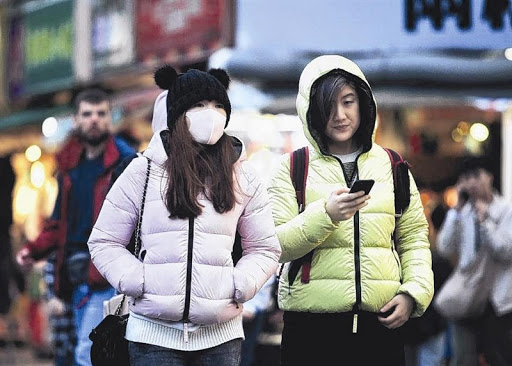

In [8]:
Image.open("/content/images/maksssksksss0.png")

In [9]:
# Converting XML format data to TXT format
def xml_to_yolo_bbox(bbox, w, h):
    # xmin, ymin, xmax, ymax
    x_center = ((bbox[2] + bbox[0]) / 2) / w
    y_center = ((bbox[3] + bbox[1]) / 2) / h

    width = (bbox[2] - bbox[0]) / w
    height = (bbox[3] - bbox[1]) / h

    return [x_center, y_center, width, height]

def yolo_to_xml_bbox(bbox, w, h):
    # x_center, y_center, width, height
    w_half_len = (bbox[2] * w) / 2
    h_half_len = (bbox[3] * h) / 2

    xmin = int((bbox[0] * w) - w_half_len)
    ymin = int((bbox[1] * h) - h_half_len)
    xmax = int((bbox[0] * w) + w_half_len)
    ymax = int((bbox[1] * h) + h_half_len)

    return [xmin, ymin, xmax, ymax]

classes = ["without_mask", "with_mask", "mask_weared_incorrect"]

input_dir = "/content/annotations"
output_dir = "/content/labels"
image_dir = "/content/images"


if not os.path.isdir(output_dir):
    os.mkdir(output_dir)

import glob

files = glob.glob(os.path.join(input_dir, "*.xml"))
for fil in files:
    basename = os.path.basename(fil)
    filename = os.path.splitext(basename)[0]
    if not os.path.exists(os.path.join(image_dir, f"{filename}.png")):
        print(f"{filename} image does not exist!")
        continue

    result = []

    tree = ET.parse(fil)
    root = tree.getroot()
    width = int(root.find("size").find("width").text)
    height = int(root.find("size").find("height").text)

    for obj in root.findall("object"):
        label = obj.find("name").text

        if label not in classes:
            classes.append(label)
        index = classes.index(label)
        pil_bbox = [int(x.text) for x in obj.find("bndbox")]
        yolo_bbox = xml_to_yolo_bbox(pil_bbox, width, height)

        bbox_string = " ".join([str(x) for x in yolo_bbox])
        result.append(f"{index} {bbox_string}")

    if result:
        with open(os.path.join(output_dir, f"{filename}.txt"), "w", encoding = "utf-8") as f:
            f.write("\n".join(result))
with open("/content/classes.txt", "w", encoding = "utf-8") as f:
    f.write(json.dumps(classes))

In [10]:
with open('/content/labels/maksssksksss0.txt') as f:
    contents = f.read()
    print(contents)

0 0.18359375 0.337431693989071 0.05859375 0.10109289617486339
1 0.4013671875 0.3333333333333333 0.080078125 0.12021857923497267
0 0.6689453125 0.3155737704918033 0.068359375 0.13934426229508196


In [11]:
with open('/content/classes.txt') as f:
    contents = f.read()
    print(contents)

["without_mask", "with_mask", "mask_weared_incorrect"]


In [12]:
from pathlib import Path

def split_dataset(image_dir, label_dir, output_dir, train_ratio=0.7):

    train_img_dir = os.path.join(output_dir, 'train', 'images')
    train_label_dir = os.path.join(output_dir, 'train', 'labels')
    test_img_dir = os.path.join(output_dir, 'test', 'images')
    test_label_dir = os.path.join(output_dir, 'test', 'labels')

    Path(train_img_dir).mkdir(parents=True, exist_ok=True)
    Path(train_label_dir).mkdir(parents=True, exist_ok=True)
    Path(test_img_dir).mkdir(parents=True, exist_ok=True)
    Path(test_label_dir).mkdir(parents=True, exist_ok=True)


    image_files = [os.path.splitext(f)[0] for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]
    random.shuffle(image_files)


    split_idx = int(len(image_files) * train_ratio)


    train_files = image_files[:split_idx]
    test_files = image_files[split_idx:]


    def copy_files(files, img_src, label_src, img_dest, label_dest):
        for file in files:
            # Find the original image file (with extension)
            img_ext = None
            for f in os.listdir(img_src):
                if os.path.splitext(f)[0] == file:
                    img_ext = os.path.splitext(f)[1]
                    break

            if img_ext is None:
                print(f"Warning: Could not find image file for {file}")
                continue

            # Find the original label file (with extension)
            label_ext = None
            for f in os.listdir(label_src):
                if os.path.splitext(f)[0] == file:
                    label_ext = os.path.splitext(f)[1]
                    break

            if label_ext is None:
                print(f"Warning: Could not find label file for {file}")
                continue

            # Copy image and label files
            shutil.copy2(
                os.path.join(img_src, file + img_ext),
                os.path.join(img_dest, file + img_ext)
            )
            shutil.copy2(
                os.path.join(label_src, file + label_ext),
                os.path.join(label_dest, file + label_ext)
            )

    # Copy train files
    copy_files(train_files, image_dir, label_dir, train_img_dir, train_label_dir)

    # Copy test files
    copy_files(test_files, image_dir, label_dir, test_img_dir, test_label_dir)

    print(f"Dataset split complete!")
    print(f"Train samples: {len(train_files)}")
    print(f"Test samples: {len(test_files)}")


image_dir = '/content/images'
label_dir = '/content/labels'
output_dir = '/content/data'

split_dataset(image_dir, label_dir, output_dir, train_ratio=0.7)

Dataset split complete!
Train samples: 597
Test samples: 256


In [13]:
yaml_text = """train: /content/data/train/images
val: /content/data/test/images

nc: 3
names: ["without_mask", "with_mask", "mask_weared_incorrect"]"""

with open("/content/data/data.yaml", 'w') as file:
    file.write(yaml_text)

%cat data/data.yaml

train: /content/data/train/images
val: /content/data/test/images

nc: 3
names: ["without_mask", "with_mask", "mask_weared_incorrect"]

In [15]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics 8.3.121 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 42.3/112.6 GB disk)


In [16]:
from ultralytics import YOLO

# Load a model
model = YOLO("yolo11n.pt")

results = model.train(data="/content/data/data.yaml", epochs=50, imgsz=640)

100%|██████████| 5.35M/5.35M [00:00<00:00, 96.6MB/s]


Ultralytics 8.3.121 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/content/data/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=Non

100%|██████████| 755k/755k [00:00<00:00, 21.9MB/s]

Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

YOLO11n summary: 181 layers, 2,590,425 parameters, 2,590,409 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 103.7±26.5 MB/s, size: 413.1 KB)


train: Scanning /content/data/train/labels... 597 images, 0 backgrounds, 0 corrupt: 100%|██████████| 597/597 [00:02<00:00, 241.53it/s]

train: New cache created: /content/data/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 70.2±26.4 MB/s, size: 504.1 KB)


val: Scanning /content/data/test/labels... 256 images, 0 backgrounds, 0 corrupt: 100%|██████████| 256/256 [00:01<00:00, 206.28it/s]

val: New cache created: /content/data/test/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.48G      1.689      3.081      1.401         45        640: 100%|██████████| 38/38 [00:18<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.54it/s]

                   all        256       1549    0.00755      0.331      0.144     0.0997



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50       3.4G      1.373      1.656      1.128         59        640: 100%|██████████| 38/38 [00:14<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.73it/s]

                   all        256       1549      0.805     0.0618      0.175      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      3.42G      1.289      1.362       1.09         33        640: 100%|██████████| 38/38 [00:15<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.04it/s]

                   all        256       1549      0.756      0.383      0.376      0.219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      3.44G      1.247      1.295      1.086         39        640: 100%|██████████| 38/38 [00:16<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.22it/s]

                   all        256       1549      0.498      0.414       0.46       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      3.45G      1.228      1.146      1.055        101        640: 100%|██████████| 38/38 [00:14<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.32it/s]

                   all        256       1549      0.519      0.411      0.486      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      3.47G      1.169      1.062      1.041         45        640: 100%|██████████| 38/38 [00:15<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.06it/s]

                   all        256       1549      0.475      0.467      0.448      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      3.48G      1.177      1.021      1.058         24        640: 100%|██████████| 38/38 [00:14<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.34it/s]

                   all        256       1549      0.718      0.475      0.549       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50       3.5G      1.165     0.9908      1.035         46        640: 100%|██████████| 38/38 [00:15<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.16it/s]

                   all        256       1549      0.648      0.514      0.573      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      3.51G      1.149     0.9361      1.035         37        640: 100%|██████████| 38/38 [00:14<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.35it/s]

                   all        256       1549      0.545      0.517      0.574      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      3.53G      1.151      0.895      1.034         47        640: 100%|██████████| 38/38 [00:15<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.25it/s]

                   all        256       1549      0.926       0.46      0.553      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      3.54G      1.126     0.8719      1.022         42        640: 100%|██████████| 38/38 [00:14<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.46it/s]

                   all        256       1549      0.639      0.611      0.617       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      3.56G      1.105     0.8255      1.017         51        640: 100%|██████████| 38/38 [00:15<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.96it/s]

                   all        256       1549      0.775      0.572      0.637      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      3.56G       1.12     0.7934       1.01         39        640: 100%|██████████| 38/38 [00:14<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.49it/s]

                   all        256       1549      0.708      0.622      0.669      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      3.59G      1.109     0.7808      1.008         25        640: 100%|██████████| 38/38 [00:15<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.11it/s]

                   all        256       1549      0.731      0.563      0.631      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      3.59G      1.091     0.7751      1.009         41        640: 100%|██████████| 38/38 [00:14<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.42it/s]

                   all        256       1549      0.647      0.663      0.665      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      3.62G      1.096     0.7452      1.013         30        640: 100%|██████████| 38/38 [00:14<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.99it/s]

                   all        256       1549      0.757      0.599      0.675      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      3.62G      1.086     0.7354     0.9953         31        640: 100%|██████████| 38/38 [00:15<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.43it/s]

                   all        256       1549       0.75      0.577      0.661      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      3.64G      1.057     0.7093     0.9881         34        640: 100%|██████████| 38/38 [00:14<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.86it/s]

                   all        256       1549      0.712       0.61      0.675      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      3.65G      1.081     0.7098     0.9938         46        640: 100%|██████████| 38/38 [00:14<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.44it/s]

                   all        256       1549      0.851       0.58      0.695      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      3.67G      1.052     0.6994     0.9856         24        640: 100%|██████████| 38/38 [00:14<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.86it/s]

                   all        256       1549      0.691      0.659      0.679      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      3.68G      1.019     0.6734     0.9787         24        640: 100%|██████████| 38/38 [00:14<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.53it/s]

                   all        256       1549      0.756      0.627      0.696      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50       3.7G      1.052     0.6737     0.9881         22        640: 100%|██████████| 38/38 [00:14<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.77it/s]

                   all        256       1549      0.781      0.639      0.709      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      3.71G      1.042     0.6667     0.9781         54        640: 100%|██████████| 38/38 [00:14<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.46it/s]

                   all        256       1549      0.782      0.659       0.73      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      3.73G      1.041     0.6509     0.9858         59        640: 100%|██████████| 38/38 [00:14<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.03it/s]

                   all        256       1549      0.772      0.646      0.721       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      3.74G      1.017     0.6503     0.9761         31        640: 100%|██████████| 38/38 [00:14<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.41it/s]

                   all        256       1549      0.778      0.681      0.738      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      3.76G      1.029     0.6306     0.9679         48        640: 100%|██████████| 38/38 [00:14<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.17it/s]

                   all        256       1549      0.723      0.688      0.734      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      3.77G     0.9998     0.6188     0.9633         28        640: 100%|██████████| 38/38 [00:15<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.50it/s]

                   all        256       1549      0.818      0.616      0.722      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      3.79G       1.02     0.6317     0.9733         42        640: 100%|██████████| 38/38 [00:14<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.38it/s]

                   all        256       1549      0.769      0.646      0.729      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50       3.8G      1.006     0.6209     0.9651         31        640: 100%|██████████| 38/38 [00:15<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.37it/s]

                   all        256       1549      0.833      0.631      0.739      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      3.82G     0.9891     0.5999     0.9634         22        640: 100%|██████████| 38/38 [00:14<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.35it/s]

                   all        256       1549      0.762      0.714      0.754      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      3.83G     0.9821     0.6052     0.9657         22        640: 100%|██████████| 38/38 [00:15<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.40it/s]

                   all        256       1549      0.786      0.679       0.75      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      3.85G      1.003      0.598     0.9659         45        640: 100%|██████████| 38/38 [00:14<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.43it/s]

                   all        256       1549      0.774      0.697      0.755      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      3.86G     0.9895     0.5855     0.9645         32        640: 100%|██████████| 38/38 [00:15<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.38it/s]

                   all        256       1549      0.831      0.676      0.756      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      3.88G     0.9926      0.588     0.9632         52        640: 100%|██████████| 38/38 [00:14<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.63it/s]

                   all        256       1549      0.817      0.656      0.759      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      3.89G     0.9786     0.5795     0.9647         19        640: 100%|██████████| 38/38 [00:15<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.13it/s]

                   all        256       1549      0.859      0.649       0.76      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      3.91G     0.9806     0.5653     0.9464         32        640: 100%|██████████| 38/38 [00:15<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.39it/s]

                   all        256       1549      0.782      0.712      0.776      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      3.92G     0.9455     0.5461     0.9395         36        640: 100%|██████████| 38/38 [00:16<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.03it/s]

                   all        256       1549      0.788      0.696      0.779       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      3.94G     0.9652      0.556     0.9551         33        640: 100%|██████████| 38/38 [00:15<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.47it/s]

                   all        256       1549      0.752      0.741      0.772      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      3.95G     0.9456     0.5447     0.9482         48        640: 100%|██████████| 38/38 [00:15<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.89it/s]

                   all        256       1549      0.799      0.731      0.784      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      3.97G     0.9407     0.5442     0.9394         46        640: 100%|██████████| 38/38 [00:14<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.45it/s]

                   all        256       1549      0.867      0.698      0.791      0.516


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      3.98G     0.9181     0.5308     0.9341         22        640: 100%|██████████| 38/38 [00:17<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.60it/s]

                   all        256       1549      0.847      0.668      0.756      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50         4G     0.9207      0.516     0.9351         29        640: 100%|██████████| 38/38 [00:14<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.16it/s]

                   all        256       1549      0.907      0.668      0.787      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      4.01G     0.9033     0.4989     0.9223         13        640: 100%|██████████| 38/38 [00:14<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.46it/s]

                   all        256       1549      0.851      0.733      0.799      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      4.03G     0.8971     0.4892     0.9195         17        640: 100%|██████████| 38/38 [00:14<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.44it/s]

                   all        256       1549       0.82      0.749      0.803      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      4.04G     0.8946     0.4926     0.9256         21        640: 100%|██████████| 38/38 [00:15<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.53it/s]

                   all        256       1549      0.824      0.723      0.781      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      4.06G     0.8776     0.4753     0.9245         13        640: 100%|██████████| 38/38 [00:14<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.50it/s]

                   all        256       1549      0.792      0.728      0.778      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      4.07G     0.8709     0.4694     0.9147         58        640: 100%|██████████| 38/38 [00:15<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.10it/s]

                   all        256       1549      0.865      0.698      0.777      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      4.09G     0.8642     0.4754     0.9125         25        640: 100%|██████████| 38/38 [00:14<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.67it/s]

                   all        256       1549      0.839      0.713      0.785      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50       4.1G     0.8732     0.4662     0.9104         34        640: 100%|██████████| 38/38 [00:14<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.88it/s]

                   all        256       1549      0.882      0.696      0.792      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      4.12G     0.8538     0.4606     0.9082         19        640: 100%|██████████| 38/38 [00:14<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.43it/s]

                   all        256       1549      0.905      0.692      0.788      0.515



50 epochs completed in 0.272 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.121 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,737 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.26it/s]


                   all        256       1549       0.82       0.75      0.803      0.518
          without_mask         95        298      0.833      0.754      0.819      0.503
             with_mask        227       1210       0.89      0.861      0.923      0.618
 mask_weared_incorrect         30         41      0.738      0.634      0.667      0.432
Speed: 0.3ms preprocess, 2.7ms inference, 0.0ms loss, 5.3ms postprocess per image
Results saved to runs/detect/train


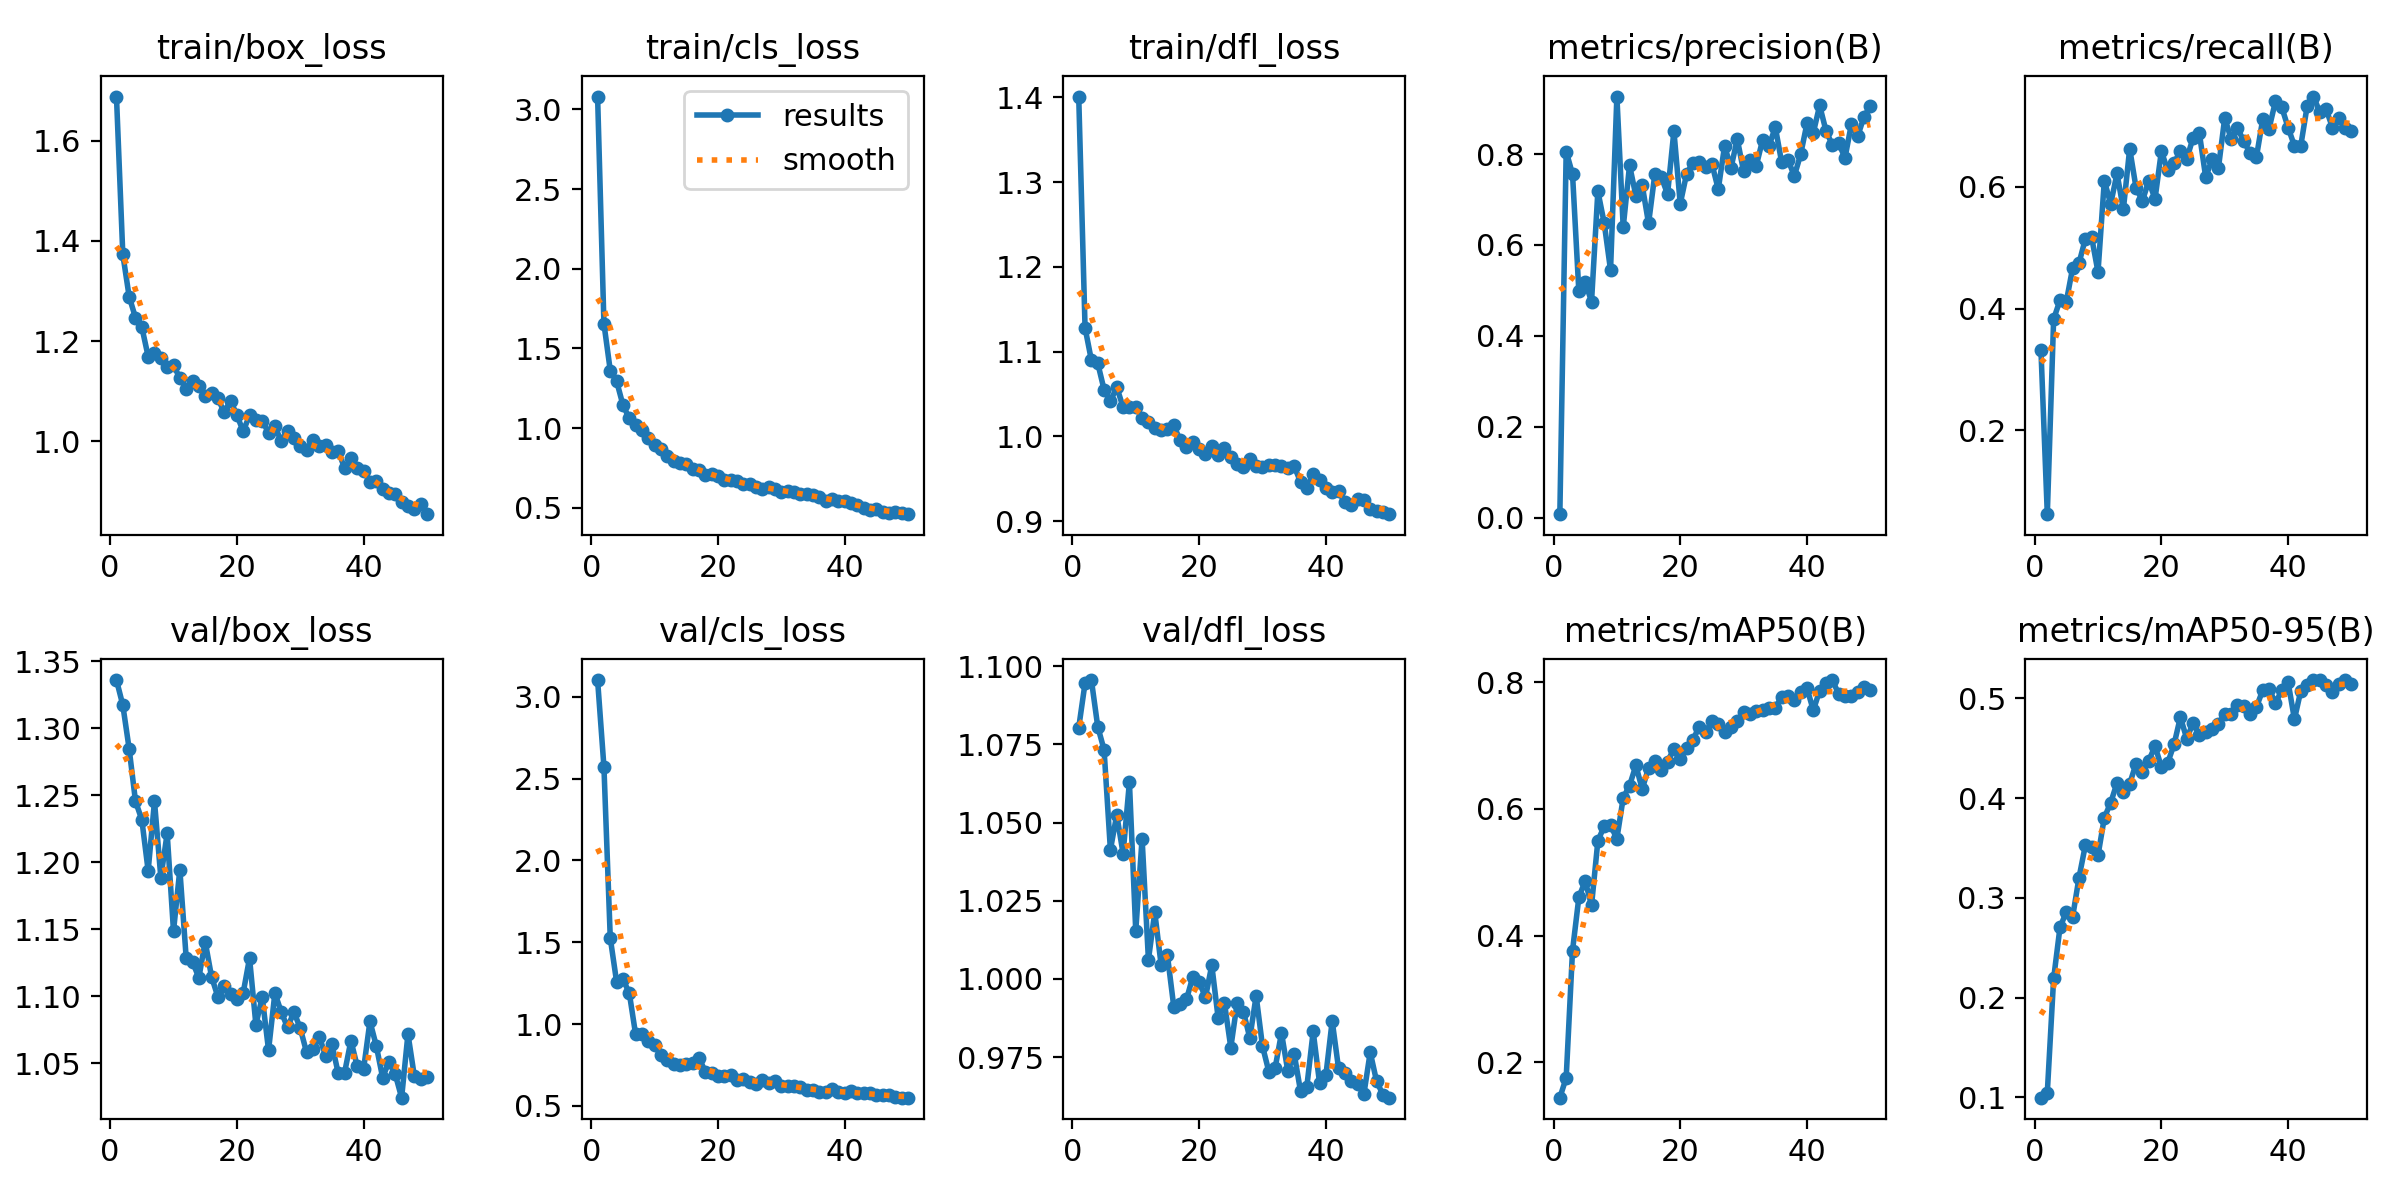

In [17]:
Image.open("/content/runs/detect/train/results.png")

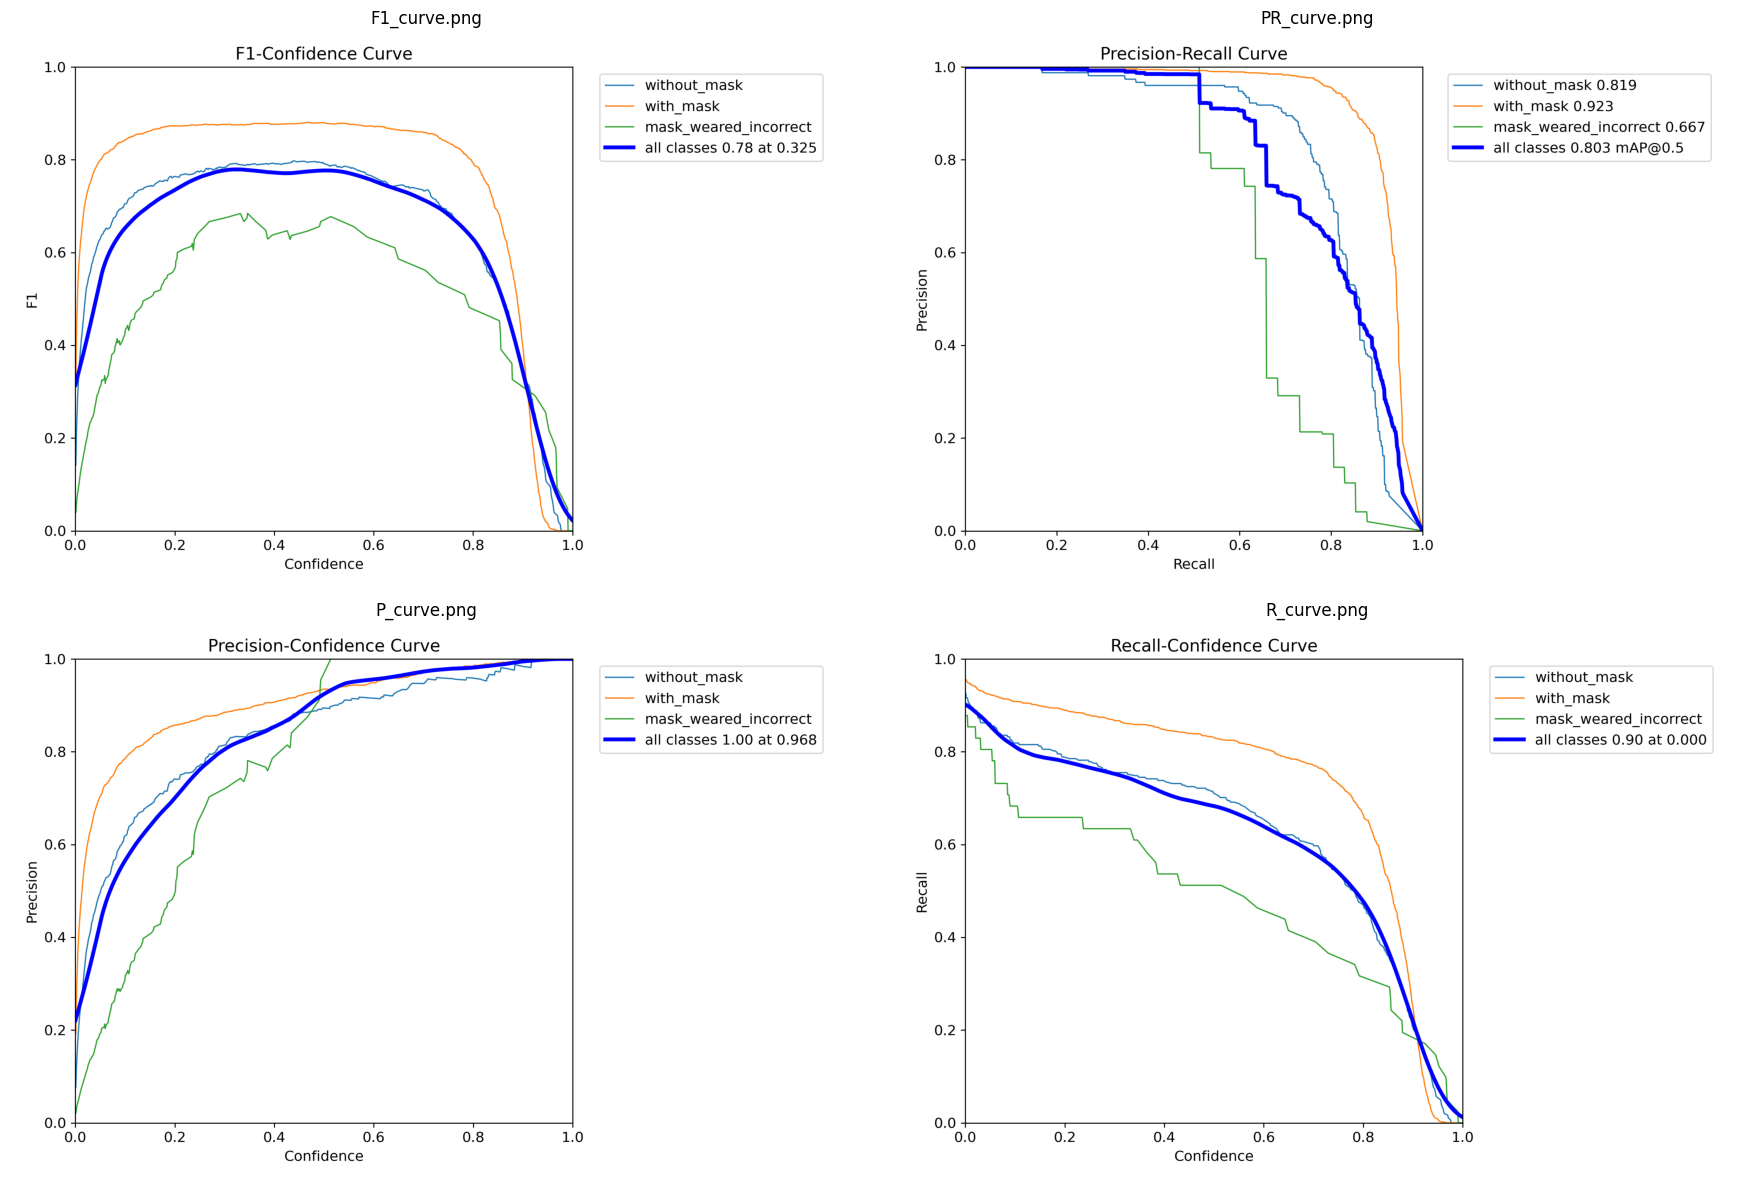

In [28]:
import matplotlib.image as mpimg

image_paths = [
    "/content/runs/detect/train/F1_curve.png",
    "/content/runs/detect/train/PR_curve.png",
    "/content/runs/detect/train/P_curve.png",
    "/content/runs/detect/train/R_curve.png",
]


plt.figure(figsize=(18, 12))

for i, img_path in enumerate(image_paths, 1):
    if os.path.exists(img_path):
        plt.subplot(2, 2, i)
        img = mpimg.imread(img_path)
        plt.imshow(img)
        plt.title(os.path.basename(img_path))
        plt.axis('off')
    else:
        print(f"Image not found: {img_path}")

plt.tight_layout()
plt.show()

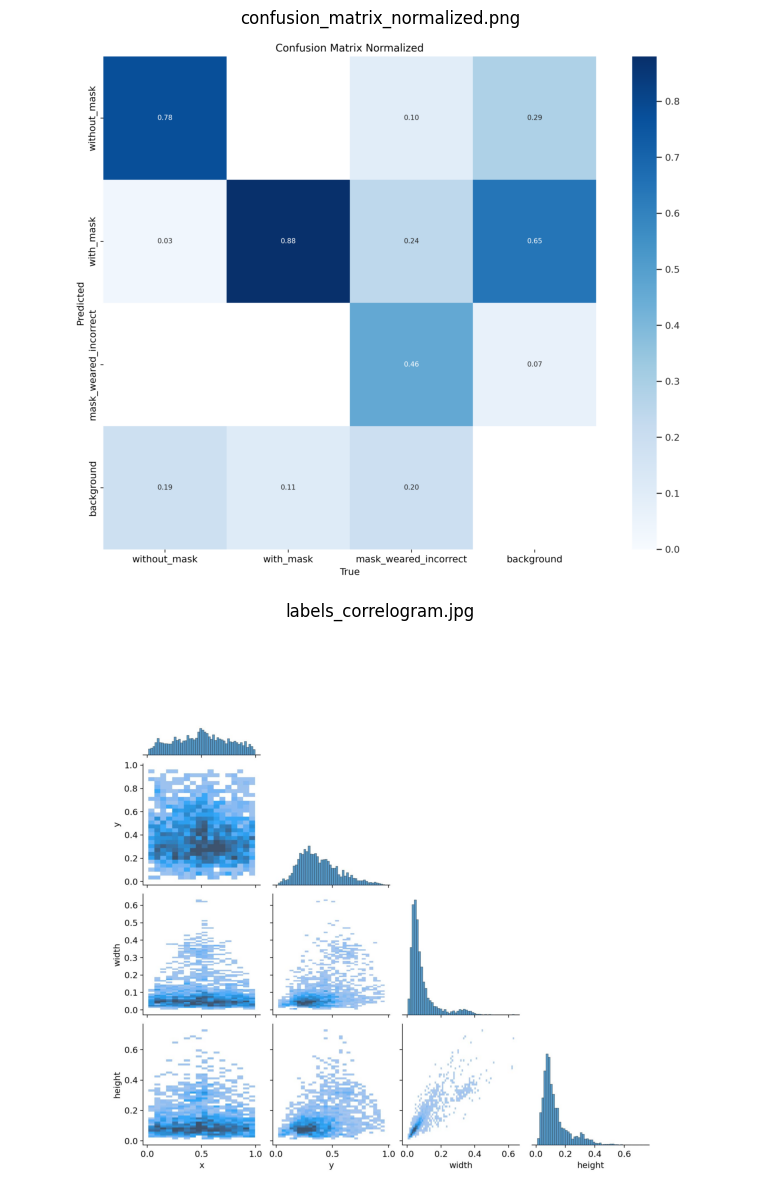

In [29]:
image_paths = [
    "/content/runs/detect/train/confusion_matrix_normalized.png",
    "/content/runs/detect/train/labels_correlogram.jpg"
]

plt.figure(figsize=(18, 12))

for i, img_path in enumerate(image_paths, 1):
    if os.path.exists(img_path):
        plt.subplot(2, 1, i)
        img = mpimg.imread(img_path)
        plt.imshow(img)
        plt.title(os.path.basename(img_path))
        plt.axis('off')
    else:
        print(f"Image not found: {img_path}")

plt.tight_layout()
plt.show()

In [19]:
!yolo predict model=/content/runs/detect/train/weights/best.pt source='/content/data/test/images'

Ultralytics 8.3.121 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,737 parameters, 0 gradients, 6.3 GFLOPs

image 1/256 /content/data/test/images/maksssksksss100.png: 384x640 3 with_masks, 43.4ms
image 2/256 /content/data/test/images/maksssksksss106.png: 448x640 (no detections), 45.2ms
image 3/256 /content/data/test/images/maksssksksss108.png: 384x640 1 without_mask, 8 with_masks, 9.0ms
image 4/256 /content/data/test/images/maksssksksss11.png: 448x640 1 without_mask, 22 with_masks, 1 mask_weared_incorrect, 9.0ms
image 5/256 /content/data/test/images/maksssksksss110.png: 448x640 14 without_masks, 17 with_masks, 8.6ms
image 6/256 /content/data/test/images/maksssksksss113.png: 448x640 1 without_mask, 5 with_masks, 9.0ms
image 7/256 /content/data/test/images/maksssksksss117.png: 640x512 1 with_mask, 44.4ms
image 8/256 /content/data/test/images/maksssksksss12.png: 448x640 3 without_masks, 14 with_masks, 10.2ms
image 9/256 /content/d

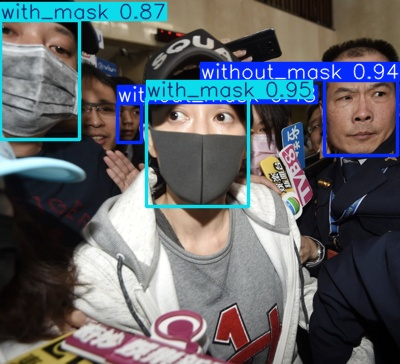

In [23]:
Image.open('/content/runs/detect/predict/maksssksksss148.jpg')